# Introduction to OOP in Python, Part 2
In part 2 we will cover the topic of class inheritance.

In [1]:
import numpy as np

We have copied the code from the last tutorial into a *local* package "mylib".

In [2]:
from mylib.TreeNode import TreeNode

TreeNode has loaded


### Recap:

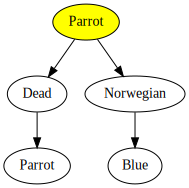

In [3]:
nd1 = TreeNode('Parrot')
nd1.left = TreeNode('Dead')
nd1.right = TreeNode('Norwegian')
nd1.right.right = TreeNode('Blue')
nd1.left.right = TreeNode('Parrot')
nd1.plot()

## Inheritance and subclasses
We currently have a generic TreeNode class, but there's nothing particularly *algebraic* about the implementation. We might expect an algebraic expression tree to be built from nodes representing variables, constants and functions. We would expect to be able to evaluate these based on some data. It might also be useful to have methods to generate new trees or nodes and to limit the size of trees based on the depth of the tree. 

To do this we do not need to build new classes from scratch; we can create a new class that is a *subclass* of one or more existing classes. Such classes will inherit the properties and methods of their *superclasses*, although we can modify or *override* them as well as add new ones. 

In fact, all classes are implicitly subclasses of the **object class**.

We are switching from thinking of object as *containers* of other objects to thinking of objects as being *hierarchically related*. Think that rather than dogs and cats as *having* legs, but that dogs and cats *are* animals, and all animals share certain properties and behaviors aka methods, although details may differ: dogs go 'woof' and cats go 'meow', both use the *makenoise* method.

In [4]:
?object

Init signature: object()
Docstring:      The most base type
Type:           type
Subclasses:     type, weakref, weakcallableproxy, weakproxy, int, bytearray, bytes, list, NoneType, NotImplementedType, ...


It makes good sense to implement a basic `ExpressionTree` class that includes the properties and methods common to all algebraic tree nodes. We will create place-holders for methods that we know we will need for later implementation.

In [5]:
class ExpressionTree(TreeNode):
    # ExpressionTree is a subclass of TreeNode
    
    import numpy as np
    
    # Override __init__
    def __init__(self,name, parent=None):
        super().__init__(name,parent)
        self.arity = 2 #how many child nodes; Const, Var = 0, Unary function =1, binary function = 2
    
    @property
    def findRoot(self):
        if self.parent is None:
            return self
        else:
            return self.parent.findRoot
    
    @property
    def getDepth(self):
        if self.parent is None:
            return 1
        else:
            return self.parent.getDepth+1
        
    @property
    def getMaxd(self):
        if self.left and self.right:
            d = max(self.left.getMaxd,self.left.getMaxd)
            return d + 1
        if self.left:
            d = self.left.getMaxd
            return d + 1
        if self.right:
            d = self.right.getMaxd
            return d + 1
        return 1
    
    @property
    def getMaxdFromRoot(self):
        return self.findRoot.getMaxd
            
    def evaluate(self,data=None):
        return np.NaN()
    
    def grow(self,maxd=5):
        d = self.getDepth 
        if d < maxd and self.arity > 0:
            self.left = ExpressionTree('L'+ str(d+1),self)
            self.left.grow(maxd)
        if d < maxd and self.arity > 1:
            self.right = ExpressionTree('R'+ str(d+1),self)
            self.right.grow(maxd)
    
    def clone(self):
        raise NotImplementedError
    
    def mutate(self):
        raise NotImplementedError
    
    

In [6]:
et = ExpressionTree('Root')

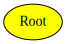

In [7]:
et.plot()

In [8]:
et.getDepth

1

In [9]:
et.grow(4)

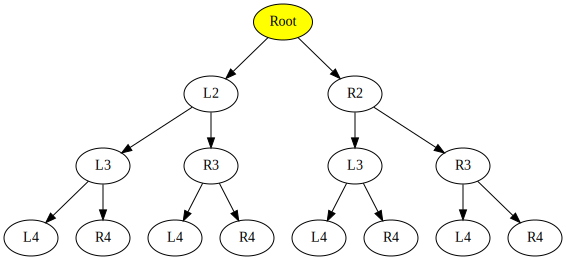

In [10]:
et.plot()

In [11]:
et.getMaxdFromRoot

4

In [12]:
et.left.left.getMaxd

2

In [13]:
et.left.left.getMaxdFromRoot

4

Two methods of our class, `clone` and `mutate` are not complete; we may have used `pass`, the Python *do nothing* keyword, but instead we are using `raise NotImplementedError` ensures we won't forget to actually complete these methods:

In [14]:
et.mutate()

NotImplementedError: 

We will come back to these later.

## When a copy is not a copy?
Certain Python classes such as strings and numbers are *immutable*. Once created, they cannot be changed. Any operation that appears to alter them in fact involves making a new copy of the object.

In [15]:
s = "Sam I am"
s

'Sam I am'

In [16]:
t = s.replace('S','P')
t

'Pam I am'

In [17]:
s

'Sam I am'

*Mutable* objects such as lists, dictionaries, sets and instances our `ExpressionTree` class behave differently:

In [18]:
et = ExpressionTree('Root')

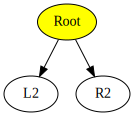

In [19]:
et.grow(2)
et.plot()

When we 'copy' `et` to `et2`, and alter `et2`, we also alter `et`:

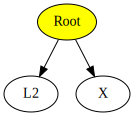

In [20]:
et2 = et
et2.right.name = 'X'
et2.plot()

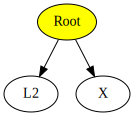

In [21]:
et.plot()

In [22]:
import copy

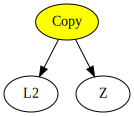

In [23]:
et2 = copy.copy(et)
et2.name = 'Copy'
et2.right.name = 'Z'
et2.plot()

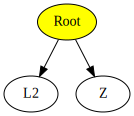

In [24]:
et.plot()

This is a **shallow copy** the object is copied, but any contained objects are still references to the originals. We would have expected `X` rather than `Z`.

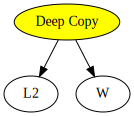

In [25]:
et2 = copy.deepcopy(et)
et2.name = 'Deep Copy'
et2.right.name = 'W'
et2.plot()

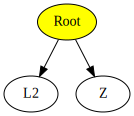

In [26]:
et.plot()

Now working as expected. `W` is a new copy of `Z`.

### Deep Copy pitfalls

An object that has *circular references*, that is implicit or explicit references to itself, may cause an infinite recursion loop with any naive implementation of deepcopy. Fortunately, deepcopy from the copy module circumvents this by keeping track of objects it has already seen.

It is still possible that circular references may throw up unexpected behaviour with deepcopy.

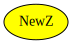

In [27]:
new_z = copy.deepcopy(et.right)
new_z.name = 'NewZ'
new_z.plot()

In [28]:
r = new_z.findRoot

del(new_z) #throw away ref to new_z as we now have the root, r.

r.name = 'NewRoot'

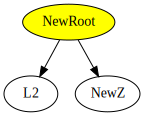

In [29]:
r.plot()

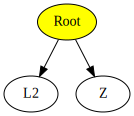

In [30]:
et.plot()

Deep copying `Z` has copied the entire tree! `NewRoot` is copy of `Root`.

In [31]:
?id

Signature: id(obj, /)
Docstring:
Return the identity of an object.

This is guaranteed to be unique among simultaneously existing objects.
(CPython uses the object's memory address.)
Type:      builtin_function_or_method


In [32]:
id(et) == id(r)

False

The other issue with deepcopy is that it will blithely copy large component objects with the resulting impact on speed and memory usage. We will illustrate this with a quick *monkey patch*.

In [33]:
et.bigdata = np.ones(1000000)

In [34]:
et3 = copy.deepcopy(et)

In [35]:
id(et.bigdata) == id(et3.bigdata)

False

In [36]:
%%timeit
et3 = copy.deepcopy(et)

1.7 ms ± 27.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [37]:
%%timeit
et3 = copy.copy(et)

2.38 µs ± 136 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [38]:
et3 = copy.copy(et)

In [39]:
id(et.bigdata) == id(et3.bigdata)

True

Two options to get round this 
- avoid using bigdata in object properties, i.e. `myobj.processdata(data)` rather than `myobj.data=data; myobj.processdata()` - which, however, breaks the OOP concept of encapsulation.
- define `__deepcopy__` and implement a customised deepcopy, ignoring properties that do not need to be deep copied.

## To be continued...